<img src="./images/DLI_Header.png" style="width: 400px;">

# 평가

오늘의 과정을 마치신 것을 축하드립니다! 유익한 기술을 배우고 즐거운 시간 보내셨기를 바랍니다. 이제 습득한 기술을 테스트해볼 시간입니다. 이 평가에서는 신선한 과일과 썩은 과일을 인식할 수 있는 새 모델을 트레이닝하게 됩니다. 모델의 검증 정확도 `92%`에 도달해야 평가에 합격할 수 있지만, 가능하다면 더 높은 점수를 달성해 보시기 바랍니다. 이전 연습에서 배운 기술을 사용해야 합니다. 구체적으로는 전이 학습, 데이터 증강 및 파인튜닝을 조합해서 사용할 것을 권장합니다. 검증 데이터세트에 대해 최소 92%의 정확도에 도달하도록 모델을 트레이닝한 후에는 모델을 저장한 다음 정확도를 평가하십시오. 시작하겠습니다! 

## 데이터세트

이 연습에서는 신선한 과일과 썩은 과일을 인식하도록 모델을 트레이닝하게 됩니다. 데이터세트는 [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification)에서 가져오게 됩니다. Kaggle은 이 수업 이후에 프로젝트를 시작하는 데 관심이 있는 경우 유용하게 활용할 수 있는 웹사이트입니다. 데이터세트 구조는 `fruits` 폴더에 있습니다. 신선한 사과, 신선한 오렌지, 신선한 바나나, 썩은 사과, 썩은 오렌지, 썩은 바나나, 이렇게 여섯 가지 과일 범주가 있습니다. 즉, 성공적으로 분류를 수행하기 위해서는 모델에 6개의 뉴런으로 이루어진 출력 레이어가 필요합니다. 또한 범주가 3개 이상이므로 `categorical_crossentropy`로 모델을 컴파일해야 합니다.

<img src="images/fruits.png" style="width: 600px;">

## ImageNet 기본 모델 로드

ImageNet으로 사전 트레이닝된 모델로 시작할 것을 권장합니다. 가중치가 올바른 모델을 로드하고 입력 모양을 설정하고 모델의 마지막 레이어를 제거하도록 선택합니다. 이미지에는 높이, 너비와 채널 수, 이렇게 세 개의 차원이 있습니다. 이러한 사진은 컬러 형식이므로 빨간색, 초록색, 파란색을 위한 3개의 채널이 있습니다. 입력 모양은 채워져 있습니다. 이를 변경할 수 없으며, 변경할 경우 평가에서 불합격하게 됩니다. 사전 트레이닝된 모델을 설정하기 위한 참조자료가 필요한 경우 전이 학습을 구현한 [노트북 05b](05b_presidential_doggy_door.ipynb)를 참조하십시오.

In [2]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

2022-04-09 10:22:47.640095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-09 10:22:47.664954: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8468146090 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-09 10:22:47.664969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


## 기본 모델 동결

다음으로는, [notebook 05b](05b_presidential_doggy_door.ipynb)에서 했던 것처럼 기본 모델을 동결시킬 것을 권장합니다. 이렇게 하는 이유는 ImageNet 데이터세트에서 학습된 모든 내용이 초기 트레이닝에서 손상되지 않도록 하기 위함입니다.

In [3]:
# Freeze base model
base_model.trainable = False

## 모델에 레이어 추가

이제 레이어를 사전 트레이닝된 모델에 추가해야 합니다. [노트북 05b](05b_presidential_doggy_door.ipynb)를 가이드로 활용할 수 있습니다. 마지막 밀집 레이어에 각별히 주의하여 올바른 뉴런 수를 포함해 다양한 유형의 과일을 분류할 수 있도록 하십시오.

In [4]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


## 모델 컴파일

손실 및 지표 옵션으로 모델을 컴파일해야 합니다. 바이너리 분류 문제가 아니라 여러 다양한 범주에 대한 트레이닝을 진행 중임을 기억하십시오.

In [6]:
model.compile(loss = 'categorical_crossentropy' , metrics = ['accuracy'])

## 데이터 증강

원하는 경우 데이터를 증강하여 데이터세트를 개선해 보십시오. 증강 예시는 [노트북 04a](04a_asl_augmentation.ipynb) 및 [노트북 05b](05b_presidential_doggy_door.ipynb)를 자유롭게 참조하십시오. [Keras ImageDataGenerator 클래스](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)에 관한 문서도 있습니다. 이 단계는 선택 사항이지만 92% 정확도를 달성하는 데 도움이 될 수 있습니다.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically


## 데이터세트 로드

이제 트레이닝 및 검증 데이터세트를 로드해야 합니다. 이미지의 적절한 폴더와 적절한 `target_size`를 선택하십시오(생성한 모델의 높이 및 너비 입력과 일치해야 함). 참조 자료를 원한다면 [노트북 05b](05b_presidential_doggy_door.ipynb)를 확인하면 됩니다.

In [8]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('data/dataset/train', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode="categorical")
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('data/dataset/test', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [9]:
print(train_it.samples)
print(train_it.batch_size)

10901
32


## 모델 트레이닝

이제 모델을 트레이닝할 시간입니다! `train` 및 `valid` 반복자(iterator)를 `fit` 함수로 전달하고 원하는 에포크 수를 설정하십시오.

In [10]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=5)


Epoch 1/5
341/340 [==============================] - 1048s 3s/step - loss: 0.6021 - accuracy: 0.8310 - val_loss: 0.2255 - val_accuracy: 0.9244
Epoch 2/5
341/340 [==============================] - 963s 3s/step - loss: 0.1365 - accuracy: 0.9543 - val_loss: 0.1133 - val_accuracy: 0.9600
Epoch 3/5
341/340 [==============================] - 991s 3s/step - loss: 0.0944 - accuracy: 0.9668 - val_loss: 0.1049 - val_accuracy: 0.9640
Epoch 4/5
341/340 [==============================] - 1045s 3s/step - loss: 0.0722 - accuracy: 0.9760 - val_loss: 0.0705 - val_accuracy: 0.9741
Epoch 5/5
341/340 [==============================] - 1040s 3s/step - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.0621 - val_accuracy: 0.9789


In [11]:
# model save
model.save("trans_model/model1.h5")
print('Saved model to disk')

Saved model to disk


In [14]:
# model load
loaded_model = keras.models.load_model('trans_model/model1.h5')
loaded_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


## 파인튜닝을 위해 모델 동결 해제

이미 92%의 검증 정확도에 도달한 경우 이 다음 단계는 선택 사항입니다. 도달하지 않은 경우에는 매우 낮은 학습률로 모델을 파인튜닝할 것을 권장합니다.

In [15]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
loaded_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss='categorical_crossentropy' , metrics=['accuracy'])

# Compile the model with a low learning rate
# model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
#               loss='categorical_crossentropy' , metrics=['accuracy'])

In [19]:
history = loaded_model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=5)

Epoch 1/5
341/340 [==============================] - 970s 3s/step - loss: 0.0429 - accuracy: 0.9851 - val_loss: 0.0485 - val_accuracy: 0.9826
Epoch 2/5
341/340 [==============================] - 1023s 3s/step - loss: 0.0339 - accuracy: 0.9877 - val_loss: 0.0480 - val_accuracy: 0.9830
Epoch 3/5
341/340 [==============================] - 1030s 3s/step - loss: 0.0351 - accuracy: 0.9878 - val_loss: 0.0511 - val_accuracy: 0.9804
Epoch 4/5
341/340 [==============================] - 1055s 3s/step - loss: 0.0343 - accuracy: 0.9888 - val_loss: 0.0627 - val_accuracy: 0.9826
Epoch 5/5
341/340 [==============================] - 1088s 3s/step - loss: 0.0363 - accuracy: 0.9874 - val_loss: 0.0530 - val_accuracy: 0.9822


## 모델 평가

이제 모델의 검증 정확도 92% 이상에 도달했다면 좋겠지만 그렇지 못한 경우에는 돌아가서 트레이닝의 에포크를 더 실행하거나 데이터 증강을 조정해야 할 수 있습니다. 

검증 정확도가 만족스러운 경우에는 다음 셀을 실행하여 모델을 평가하십시오. 평가 함수는 튜플을 반환하며, 여기서 첫 번째 값은 손실, 두 번째 값은 정확도입니다. 합격하려면 모델의 정확도 값이 `92% or higher`이어야 합니다. 

In [25]:
loaded_model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

85/84 [==============================] - 206s 2s/step - loss: 0.0550 - accuracy: 0.9855


[0.0550149641931057, 0.9855448603630066]

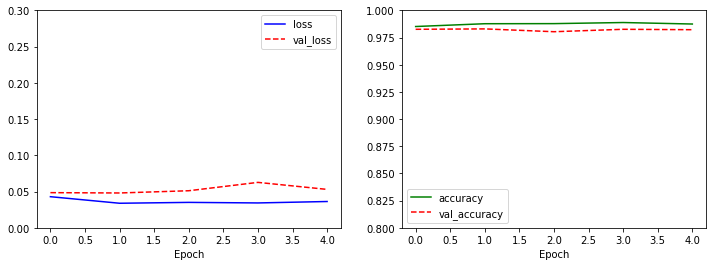

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0.0,0.3)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1.0)
plt.legend()

plt.show()

## 평가 실행

모델을 평가하려면 다음 두 개의 셀을 실행하십시오.

**참고:** `run_assessment`는 모델이 `model`로 명명되었고 검증 데이터 반복자가 `valid_it`으로 명명되었음을 가정합니다. 어떤 이유로든 이러한 변수 이름을 수정한 경우에는 `run_assessment`로 전달된 인수의 이름을 업데이트하십시오.

In [ ]:
from run_assessment import run_assessment

In [ ]:
run_assessment(model, valid_it)

## 인증서 생성

평가에 합격한 경우 아래에 표시된 과정 페이지로 돌아가 "평가 작업" 버튼을 클릭하면 과정 인증서가 생성됩니다.

<img src="images/assess_task.png" style="width: 800px;">